[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JorisRoels/deep-learning-biology/blob/main/exercises/solutions/2020-dlb-1-neural-networks-solution.ipynb)

# Exercise 1: Neural Networks

In this notebook, we will be using neural networks to identify enzyme sequences from protein sequences. 

The structure of these exercises is as follows: 

1. [Import libraries and download data](#scrollTo=ScagUEMTMjlK)
2. [Data pre-processing](#scrollTo=ohZHyOTnI35b)
3. [Building a neural network with PyTorch](#scrollTo=kIry8iFZI35y)
4. [Training & validating the network](#scrollTo=uXrEb0rTI35-)
5. [Improving the model](#scrollTo=o76Hxj7-Mst5)
6. [Understanding the model](#scrollTo=Ult7CTpCMxTi)

This notebook is largely based on the research published in: 

Li, Y., Wang, S., Umarov, R., Xie, B., Fan, M., Li, L., & Gao, X. (2018). DEEPre: Sequence-based enzyme EC number prediction by deep learning. Bioinformatics, 34(5), 760–769. https://doi.org/10.1093/bioinformatics/btx680

## 1. Import libraries and download data
Let's start with importing the necessary libraries. 

In [1]:
import pickle
import numpy as np
import random
import os
import matplotlib.pyplot as plt
plt.rcdefaults()
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from progressbar import ProgressBar, Percentage, Bar, ETA, FileTransferSpeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets
import gdown
import zipfile
import os

As you will notice, Colab environments come with quite a large library pre-installed. If you need to import a module that is not yet specified, you can add it in the previous cell (make sure to run it again). If the module is not installed, you can install it with `pip`. 

To make your work reproducible, it is advised to initialize all modules with stochastic functionality with a fixed seed. Re-running this script should give the same results as long as the seed is fixed. 

In [2]:
# make sure the results are reproducible
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


We will now download the required data from a public Google Drive repository. The data is stored as a zip archive and automatically extracted to the `data` directory in the current directory. 

In [3]:
# fields
url = 'http://data.bits.vib.be/pub/trainingen/DeepLearning/data-1.zip'
cmp_data_path = 'data.zip'

# download the compressed data
gdown.download(url, cmp_data_path, quiet=False)

# extract the data
zip = zipfile.ZipFile(cmp_data_path)
zip.extractall('')

# remove the compressed data
os.remove(cmp_data_path)

Downloading...
From: http://data.bits.vib.be/pub/trainingen/DeepLearning/data-1.zip
To: /content/data.zip
100%|██████████| 840k/840k [00:00<00:00, 1.21MB/s]


## 2. Data pre-processing

The data are protein sequences and stored in binary format as pickle files. However, we encode the data to a binary matrix $X$ where the value at position $(i,j)$ represents the absence or presence of the protein $i$ in the sequence $j$: 

$$
X_{i,j}=\left\{
        \begin{array}{ll}
          1 \text{ (protein } i \text{ is present in sequence } j \text{)}\\
          0 \text{ (protein } i \text{ is not present in sequence } j \text{)}
        \end{array} 
        \right.
$$

The corresponding labels $y$ are also binary, they separate the enzyme from the non-enzyme sequences: 

$$
y_{j}=\left\{
      \begin{array}{ll}
        1 \text{ (sequence } j \text{ is an enzyme)}\\
        0 \text{ (sequence } j \text{ is not an enzyme)}
      \end{array} 
      \right.
$$

In [4]:
def encode_data(f_name_list, proteins):
    
    with open(f_name_list,'rb') as f:
        name_list = pickle.load(f)

    encoding = []
    widgets = ['Encoding data: ', Percentage(), ' ', Bar(), ' ', ETA()]
    pbar = ProgressBar(widgets=widgets, maxval=len(name_list))
    pbar.start()
    for i in range(len(name_list)):
        single_encoding = np.zeros(len(proteins))
        if name_list[i] != []:
            for protein_name in name_list[i]:
                single_encoding[proteins.index(protein_name)] = 1
        encoding.append(single_encoding)
        pbar.update(i)
    pbar.finish()
    
    return np.asarray(encoding, dtype='int8')

# specify where the data is stored
data_dir = 'data-1'
f_name_list_enzymes = os.path.join(data_dir, 'Pfam_name_list_new_data.pickle')
f_name_list_nonenzyme = os.path.join(data_dir, 'Pfam_name_list_non_enzyme.pickle')
f_protein_names = os.path.join(data_dir, 'Pfam_model_names_list.pickle')

# load the different proteins
with open(f_protein_names,'rb') as f:
    proteins = pickle.load(f)
num_proteins = len(proteins)

# encode the sequences to a binary matrix
enzymes = encode_data(f_name_list_enzymes, proteins)
non_enzymes = encode_data(f_name_list_nonenzyme, proteins)

# concatenate everything together
X = np.concatenate([enzymes, non_enzymes], axis=0)

# the labels are binary (1 for enzymes, 0 for non-enzymes) and are one-hot encoded
y = np.concatenate([np.ones([22168,1]), np.zeros([22168,1])], axis=0).flatten()

# print a few statistics
print('There are %d sequences with %d protein measurements' % (X.shape[0], X.shape[1]))
print('There are %d enzyme and %d non-enzyme sequences' % (enzymes.shape[0], non_enzymes.shape[0]))

Encoding data: 100% |##########################################| Time:  0:00:09
Encoding data: 100% |##########################################| Time:  0:00:06


There are 44336 sequences with 16306 protein measurements
There are 22168 enzyme and 22168 non-enzyme sequences


Here is a quick glimpse in the data. For a random selection of proteins, we plot the amount of times it was counted in the enzyme and non-enzyme sequences. 

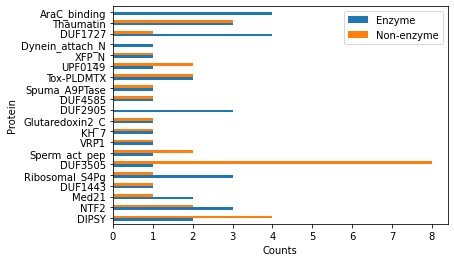

In [5]:
# selection of indices for the proteins
inds = np.random.randint(num_proteins, size=20)
proteins_subset = [proteins[i] for i in inds]

# compute the sum over the sequences
enzymes_sum = np.sum(enzymes, axis=1)
non_enzymes_sum = np.sum(non_enzymes, axis=1)

# plot the counts on the subset of proteins
df = pd.DataFrame({'Enzyme': enzymes_sum[inds], 'Non-enzyme': non_enzymes_sum[inds]}, index=proteins_subset)
df.plot.barh()
plt.xlabel('Counts')
plt.ylabel('Protein')
plt.show()

To evaluate our approaches properly, we will split the data in a training and testing set. We will use the training set to train our algorithms and the testing set as a separate set of unseen data to evaluate the performance of our models.

In [6]:
test_ratio = 0.5 # we will use 50% of the data for testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed)

print('%d sequences for training and %d for testing' % (x_train.shape[0], x_test.shape[0]))

22168 sequences for training and 22168 for testing


## 3. Building a neural network with PyTorch

Now, we have to implement the neural network and train it. For this, we will use the high-level deep learning library [PyTorch](https://pytorch.org/). PyTorch is a well-known, open-source, machine learning framework that has a comprehensive set of tools and libraries and accelerates research prototyping. It also supports transparant training of machine learning models on GPU devices, which can benefit runtimes significantly. The full documentation can be found [here](https://pytorch.org/docs/stable/index.html). 

Let's start by defining the architecture of neural network. 

**Exercise**: build a network with a single hidden layer with PyTorch: 
- The first layer will be a [fully connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) with [relu](https://pytorch.org/docs/stable/nn.functional.html?highlight=relu#torch.nn.functional.relu) activation that transforms the input features to a 512 dimensional (hidden) feature vector representation. 
- The output layer is another [fully connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) that transforms the hidden representation to a class probability distribution. 
- Print the network architecture to validate your architecture. 
- Run the network on a random batch of samples. Note that you have to transfer the numpy ndarray type inputs to floating point [PyTorch tensors](https://pytorch.org/docs/stable/tensors.html). 

In [7]:
# define the number of classes
num_classes = 2

# The network will inherit the Module class
class Net(nn.Module):

    def __init__(self, n_features=512):
        super(Net, self).__init__()
        # first (input) layer
        self.hidden = nn.Linear(num_proteins, n_features) 
        # final layer that generates the output
        self.output = nn.Linear(n_features, num_classes)

    def forward(self, x):
        # forward propagation of the network, we only use relu activation in the first two layers
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x

# initialize the network and print the architecture
n_features = 512
net = Net(n_features=n_features)
print(net)

# run the network on a batch of samples
# note that we have to transfer the numpy ndarray type inputs to float torch tensors
inputs = torch.from_numpy(x_test[:4]).float()
outputs = F.softmax(net(inputs), dim=1)
print(outputs.detach().numpy())

Net(
  (hidden): Linear(in_features=16306, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=2, bias=True)
)
[[0.49327874 0.5067213 ]
 [0.49322802 0.5067719 ]
 [0.49309522 0.5069047 ]
 [0.4924999  0.5075002 ]]


The summary gives an overview of the network architecture. Note that the network is also randomly initialized and therefore returns random outputs for a set of inputs, i.e. there is a 50% chance that a sequence is (non-)enzyme. 

**Exercise**: manually compute the amount of parameters in this network and verify this with PyTorch. 

In [8]:
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('There are %d trainable parameters in the network' % n_params)

There are 8350210 trainable parameters in the network


## 4. Training and validating the network

To train this network, we still need two things: a loss function and an optimizer. For the loss function, we will use the commonly used cross entropy loss for classification. For the optimizer, we will use stochastic gradient descent (SGD) with a learning rate of 0.1. 

In [9]:
learning_rate = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

Great. Now it's time to train our model and implement backpropagation. Fortunately, PyTorch makes this relatively easy. A single optimization iteration consists of the following steps: 
1. Sample a batch from the training data: we use the convenient [data loading](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) system provided by PyTorch. You can simply enumerate over the `DataLoader` objects. 
2. Set all gradients equal to zero. You can use the [`zero_grad()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=zero_grad#torch.nn.Module.zero_grad) function. 
3. Feed the batch to the network and compute the outputs. 
4. Compare the outputs to the labels with the loss function. Note that the loss function itself is a `Module` object as well and thus can be treated in a similar fashion as the network for computing outputs. 
5. Backpropagate the gradients w.r.t. the computed loss. You can use the [`backward()`](https://pytorch.org/docs/stable/autograd.html?highlight=backward#torch.autograd.backward) function for this. 
6. Apply one step in the optimization (e.g. gradient descent). For this, you will need the optimizer's [`step()`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer.step) function. 

**Exercise**: train the model with the following settings: 
- Train the network for 50 epochs
- Use a mini batch size of 1024
- Track the performance of the classifier by additionally providing the test data. We have already provided a validation function that tracks the accuracy. This function expects a network module, a binary matrix $X$ of sequences, their corresponding labels $y$ and the batch size (for efficiency reasons) as inputs. 

In [10]:
# dataset useful for sampling (and many other things)
class ProteinSeqDataset(data.Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, i):
        return self.data[i], self.labels[i]
    
    def __len__(self):
        return len(self.data)

def validate_accuracy(net, X, y, batch_size=1024):
    
    # evaluation mode
    net.eval()
    
    # save predictions
    y_preds = np.zeros((len(y)))
    
    for b in range(len(y) // batch_size):
        
        # sample a batch
        inputs = X[b*batch_size: (b+1)*batch_size]
    
        # transform to tensors
        inputs = torch.from_numpy(inputs).float().to(device)

        # forward call
        y_pred = net(inputs)
        y_pred = F.softmax(y_pred, dim=1)[:, 1] > 0.5
        
        # save predictions
        y_preds[b*batch_size: (b+1)*batch_size] = y_pred.detach().cpu().numpy()
    
    # remaining batch
    b = len(y) // batch_size
    inputs = torch.from_numpy(X[b*batch_size:]).float().to(device)
    y_pred = net(inputs)
    y_pred = F.softmax(y_pred, dim=1)[:, 1] > 0.5
    y_preds[b*batch_size:] = y_pred.detach().cpu().numpy()
    
    # compute accuracy
    acc = accuracy_score(y, y_preds)
    
    return acc

# implementation of a single training epoch
def train_epoch(net, loader, loss_fn, optimizer):
    
    # set the network in training mode
    net.train()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data
        x = x.float().to(device)
        y = y.long().to(device)
        
        # set all gradients equal to zero
        net.zero_grad()
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred, y)
        loss_cum += loss.data.cpu().numpy()
        cnt += 1
        
        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg

# implementation of a single testing epoch
def test_epoch(net, loader, loss_fn):
    
    # set the network in training mode
    net.eval()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data
        x = x.float().to(device)
        y = y.long().to(device)
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred, y)
        loss_cum += loss.data.cpu().numpy()
        cnt += 1
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg

def train_net(net, train_loader, test_loader, loss_fn, optimizer, epochs):
    
    # transfer the network to the GPU
    net = net.cuda()
    
    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    train_acc = np.zeros((epochs))
    test_acc = np.zeros((epochs))
    for epoch in range(epochs):
        
        # training
        train_loss[epoch] = train_epoch(net, train_loader, loss_fn, optimizer)
        train_acc[epoch] = validate_accuracy(net, x_train, y_train)
        
        # testing
        test_loss[epoch] = test_epoch(net, test_loader, loss_fn)
        test_acc[epoch] = validate_accuracy(net, x_test, y_test)
        
        print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f - Test loss: %.6f - Test accuracy: %.6f' 
              % (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))
    
    return train_loss, test_loss, train_acc, test_acc

# parameters
n_epochs = 50
batch_size = 1024

# build a training and testing dataloader that handles batch sampling
train_data = ProteinSeqDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size)
test_data = ProteinSeqDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

# start training
train_loss, test_loss, train_acc, test_acc = train_net(net, train_loader, test_loader, loss_fn, optimizer, n_epochs)

Epoch     0 - Train loss: 0.692565 - Train accuracy: 0.505097 - Test loss: 0.692201 - Test accuracy: 0.496436
Epoch     1 - Train loss: 0.691568 - Train accuracy: 0.512495 - Test loss: 0.691237 - Test accuracy: 0.503338
Epoch     2 - Train loss: 0.690585 - Train accuracy: 0.591077 - Test loss: 0.690283 - Test accuracy: 0.581469
Epoch     3 - Train loss: 0.689578 - Train accuracy: 0.606099 - Test loss: 0.689295 - Test accuracy: 0.596896
Epoch     4 - Train loss: 0.688505 - Train accuracy: 0.640698 - Test loss: 0.688223 - Test accuracy: 0.632488
Epoch     5 - Train loss: 0.687332 - Train accuracy: 0.700650 - Test loss: 0.687044 - Test accuracy: 0.688425
Epoch     6 - Train loss: 0.686028 - Train accuracy: 0.752977 - Test loss: 0.685727 - Test accuracy: 0.740166
Epoch     7 - Train loss: 0.684563 - Train accuracy: 0.771337 - Test loss: 0.684235 - Test accuracy: 0.763307
Epoch     8 - Train loss: 0.682903 - Train accuracy: 0.762225 - Test loss: 0.682555 - Test accuracy: 0.755413
Epoch     

Clearly, this is the time intensive part, and it becomes more challenging with larger networks or larger datasets. GPU acceleration is therefore a crucial part. 

The code below visualizes the learning curves: these curves illustrate how the loss on the train and test set decays over time. Additionally, we also report a similar curve for the train and test accuracy. The final accuracy is also reported. 

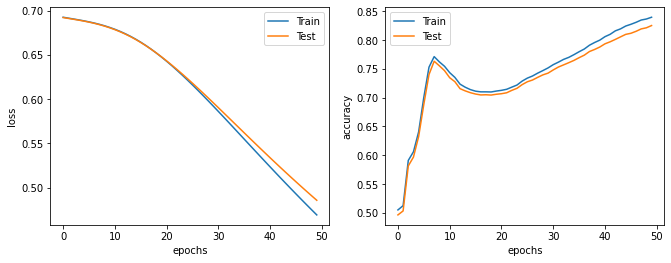

The model obtains an accuracy of 82.53%


In [11]:
def plot_learning_curves(train_loss, test_loss, train_acc, test_acc):
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(('Train', 'Test'))
    plt.subplot(1, 2, 2)
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(('Train', 'Test'))
    plt.show()

# plot the learning curves (i.e. train/test loss and accuracy)
plot_learning_curves(train_loss, test_loss, train_acc, test_acc)

# report final accuracy
print('The model obtains an accuracy of %.2f%%' % (100*test_acc[-1]))

You should achieve over 80% accuracy. There are two things we can conclude from the learning curves: 

- Training still requires a long time, especially if you would compare this to alternative classifiers such as random forests or support vector machines. 
- The testing curve has reached a plateau, whereas the training curve can still improve. You could increase the amount of epochs and train for a longer period, but this will not improve the test performance that much. Even worse, the performance on the test set would likely become worse! This is called overfitting: the optimization aims to maximize the performance on the training set, focuses on details in the training set and fails to generalize to new data. This is one of the biggest challenges in machine learning. 

## 5. Improving the model

We will try to improve the model by improving the training time and mitigating the overfitting to some extent. 

**Exercise**: Improve the model by implementing the following adjustments: 
- Train the network based on [`Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) optimization instead of stochastic gradient descent. The Adam optimizer adapts its learning rate over time and therefore improves convergence significantly. For more details on the algorithm, we refer to the [original published paper](https://arxiv.org/pdf/1412.6980.pdf). You can significantly reduce the learning rate (e.g. 0.0001) and number of training epochs (e.g. 20). 
- The first adjustment to avoid overfitting is reduce the size of the network. At first sight this may seem strange because this reduces the capacity of the network. However, large networks are more likely to focus on details in the training data because of the redundant number of neurons in the hidden layer. Experiment with smaller hidden representations (e.g. 32 or 16). 
- The second adjustment to mitigate overfitting is [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). During training, Dropout layers randomly switch off neurons (i.e. their value is temporarily set to zero). This forces the network to use the other neurons to make an appropriate decision. At test time, the dropout layers are obviously ignored and no neurons are switched off. The amount of neurons that are switched off during training is called the dropout factor (e.g. 0.50). For more details, we refer to the [original published paper](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf). 

ImprovedNet(
  (hidden): Linear(in_features=16306, out_features=64, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
  (output): Linear(in_features=64, out_features=2, bias=True)
)
Epoch     0 - Train loss: 0.680493 - Train accuracy: 0.719145 - Test loss: 0.660339 - Test accuracy: 0.688966
Epoch     1 - Train loss: 0.626672 - Train accuracy: 0.920967 - Test loss: 0.592484 - Test accuracy: 0.898593
Epoch     2 - Train loss: 0.548042 - Train accuracy: 0.910141 - Test loss: 0.514871 - Test accuracy: 0.889210
Epoch     3 - Train loss: 0.469625 - Train accuracy: 0.914110 - Test loss: 0.446936 - Test accuracy: 0.891826
Epoch     4 - Train loss: 0.405516 - Train accuracy: 0.922320 - Test loss: 0.393538 - Test accuracy: 0.899179
Epoch     5 - Train loss: 0.351323 - Train accuracy: 0.930576 - Test loss: 0.352544 - Test accuracy: 0.905855
Epoch     6 - Train loss: 0.308936 - Train accuracy: 0.939507 - Test loss: 0.321411 - Test accuracy: 0.915103
Epoch     7 - Train loss: 0.276682 - Train 

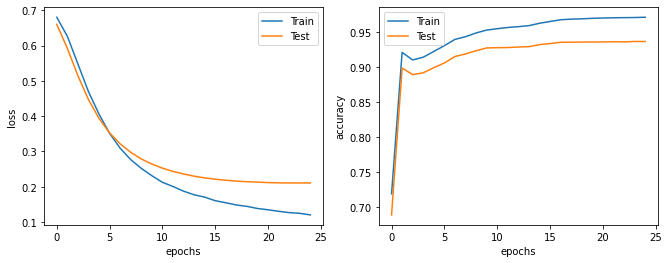

The model obtains an accuracy of 93.65%


In [12]:
# The network will inherit the Module class
class ImprovedNet(nn.Module):

    def __init__(self, n_features=512, p=0.5):
        super(ImprovedNet, self).__init__()
        # first (input) layer
        self.hidden = nn.Linear(num_proteins, n_features) 
        self.dropout = nn.Dropout(p=p)
        # final layer that generates the output
        self.output = nn.Linear(n_features, num_classes)

    def forward(self, x):
        # forward propagation of the network, we only use relu activation in the first two layers
        x = self.dropout(F.relu(self.hidden(x)))
        x = self.output(x)
        return x

# initialize the network and print the architecture
n_features = 64
p = 0.75 # dropout factor
improved_net = ImprovedNet(n_features=n_features, p=p)
print(improved_net)

# reduce the learning rate
learning_rate = 0.001
n_epochs = 25

# Adam optimization
optimizer = optim.Adam(improved_net.parameters(), lr=learning_rate)

# start training
train_loss, test_loss, train_acc, test_acc = train_net(improved_net, train_loader, test_loader, loss_fn, optimizer, n_epochs)

# plot the learning curves (i.e. train/test loss and accuracy)
plot_learning_curves(train_loss, test_loss, train_acc, test_acc)

# report final accuracy
print('The model obtains an accuracy of %.2f%%' % (100*test_acc[-1]))

Great, that looks much better! You should achieve over 93% accuracy in significantly less training time. 

Of course, there are much more ways of trying to improve the model: e.g. batch normalization, regularization, increase the amount of hidden layers, etc. In what follows, we will study the most frequently used techniques. We will provide guidelines on how to use these techniques, however, it is not always guaranteed that they will improve the model. 

## 6. Understanding the model

To gain more insight in the network, it can be useful to take a look to the hidden representations of the network. To do this, you have to propagate a number of samples through the first hidden layer of the network and visualize them using dimensionality reduction techniques. 

**Exercise**: Visualize the hidden representations of a batch of samples in 2D to gain more insight in the network's decision process: 
- Compute the hidden representation of a batch of samples. To do this, you will have to select a batch, transform this in a torch Tensor and apply the hidden and relu layer of the network on the inputs. Since these are also modules, you can use them in a similar fashion as the original network. 
- Extract the outputs of the networks as a numpy array and apply dimensionality reduction. A common dimensionality reducing method is the t-SNE algorithm. 

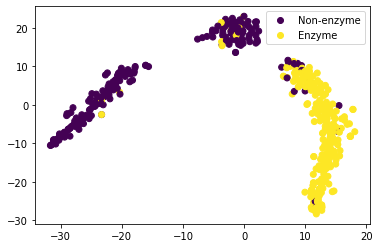

In [13]:
# select a batch of samples
n = 512
batch = x_test[:n]
batch_labels = y_test[:n]
batch = torch.from_numpy(batch).float().cuda()

# compute the hidden representation of the batch
h = F.relu(improved_net.hidden(batch))
h = h.data.cpu().numpy()

# reduce the dimensionality of the hidden representations
h_red = TSNE(n_components=2, random_state=seed).fit_transform(h)

# visualize the reduced representations and label each sample
scatter = plt.scatter(h_red[:, 0], h_red[:, 1], c=batch_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=('Non-enzyme', 'Enzyme'))
plt.show()

We can clearly identify two clusters that correspond to the two classes that we would like to predict. The network has optimized its neurons in order to separate these two classes as good as possible. Nevertheless, there also seem to be some positive samples located in the negative cluster and vice versa. These samples probably correspond to false positives and false negatives and are worth investigating further. 

Another way to analyze the network is by checking which proteins cause the highest hidden activations in enzyme and non-enzyme samples. These features are discriminative for predicting the classes. 

In [14]:
# isolate the positive and negative samples
h_pos = h[batch_labels == 1]
h_neg = h[batch_labels == 0]

# compute the mean activation
h_pos_mean = h_pos.mean(axis=0)
h_neg_mean = h_neg.mean(axis=0)

# sort the mean activations
i_pos = np.argsort(h_pos_mean)
i_neg = np.argsort(h_neg_mean)

# select the highest activations
n = 5
i_pos = i_pos[-n:][::-1]
i_neg = i_neg[-n:][::-1]

print('Discriminative features that result in high activation for enzyme prediction: ')
for i in i_pos:
    print('  - %s (mean activation value: %.3f)' % (proteins[i], h_pos_mean[i]))
print('Discriminative features that result in high activation for non-enzyme prediction: ')
for i in i_neg:
    print('  - %s (mean activation value: %.3f)' % (proteins[i], h_neg_mean[i]))

Discriminative features that result in high activation for enzyme prediction: 
  - 12TM_1 (mean activation value: 0.206)
  - 2-ph_phosp (mean activation value: 0.202)
  - 3A (mean activation value: 0.201)
  - 7kD_coat (mean activation value: 0.199)
  - 7TMR-DISMED2 (mean activation value: 0.196)
Discriminative features that result in high activation for non-enzyme prediction: 
  - 5HT_transport_N (mean activation value: 0.192)
  - 5-FTHF_cyc-lig (mean activation value: 0.185)
  - 2H-phosphodiest (mean activation value: 0.183)
  - 5_3_exonuc (mean activation value: 0.180)
  - 14-3-3 (mean activation value: 0.175)


Let's hope these proteins have an interesting meaning w.r.t. enzymes from a biological point of view! 

Understanding how neural networks make decisions is up to this day still an unresolved problem. Especially as the amount of layers increases, the extracted features tend to become more abstract and more challenging to study. If you are interested in this domain, feel free to dig a little deeper in the Explainable AI research domain. For example, [this blogpost](https://medium.com/@shagunm1210/the-explainable-neural-network-8f95256dcddb) might be a good starting point! 